# Protected Attributes vs Fairness

Our project was inspired by ProPublica's analysis on COMPAS, a software utilized by the legal system to help determine an individual's chance of recidivating. One crucial problem identified by ProPublica through their investigation was the racial bias of the results. According to the published web page on their findings, ProPublica states: "Race was also quite predictive of a higher score. While Black defendants had higher recidivism rates overall, when adjusted for this difference and other factors, they were 45 percent more likely to get a higher score than whites."

In our project, we looked at whether race affected precision and accuracy by including and excluding the race feature.

reference: https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm

## Pre-processing

Data set: https://data.iowa.gov/Correctional-System/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [66]:
# load the data set into a pandas data frame
iowa_df = pd.read_csv("3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa.csv")

# iowa_df.head(5) # Show the first 5 rows of the dataframe

In [67]:
# drop values that are incomplete
drop_row_list = ['White -', 'Black -', 'N/A -', np.nan]

iowa_clean_df = iowa_df[~iowa_df['Race - Ethnicity'].isin(drop_row_list)]

In [68]:
# creating the data frames that includes the features and labels
features_list = ['Release Type', 'Age At Release ', 'Offense Classification', 'Offense Type', 'Target Population']

features_df = iowa_clean_df[features_list]

labels_df = iowa_clean_df[['Return to Prison']]

## Visualization
### Ethnicity and Sex

In [69]:
# gets the ethnicity count and the gender count within each ethnicity group
ethnic_gender_series = iowa_clean_df.groupby(['Race - Ethnicity', 'Sex']).count().ix[:, 0]
ethnic_gender_series

Race - Ethnicity                                 Sex   
American Indian or Alaska Native - Hispanic      Female        8
                                                 Male         12
American Indian or Alaska Native - Non-Hispanic  Female       95
                                                 Male        407
Asian or Pacific Islander - Hispanic             Male          5
Asian or Pacific Islander - Non-Hispanic         Female       21
                                                 Male        171
Black - Hispanic                                 Female        3
                                                 Male         34
Black - Non-Hispanic                             Female      634
                                                 Male       5475
White - Hispanic                                 Female      111
                                                 Male       1411
White - Non-Hispanic                             Female     2463
                                  

In [70]:
# separating list out by male and female to create stacked bar plot
female_count_list = []
male_count_list = []
for i in range(ethnic_gender_series.size):
    idx = i
    if (idx) % 2 == 0:
        male_count_list.append(ethnic_gender_series[idx])
    else:
        female_count_list.append(ethnic_gender_series[idx])

# hard-coded in 0 for Asian... - Hispanic
female_count_list.insert(2, 0)

print(male_count_list)
print(female_count_list)

[8, 95, 5, 171, 34, 5475, 1411, 15121]
[12, 407, 0, 21, 3, 634, 111, 2463]


reference for label: https://python-graph-gallery.com/10-barplot-with-number-of-observation/

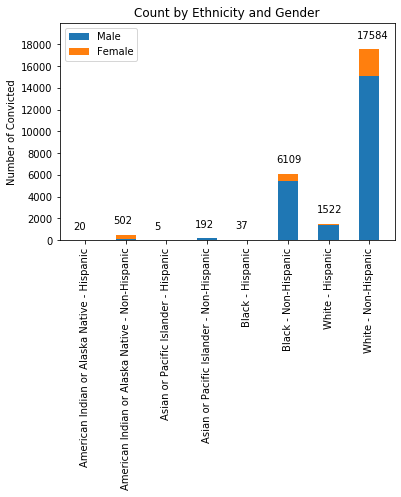

In [71]:
# create the stacked bar plot
width = 0.5
ind = np.arange(8) 

p1 = plt.bar(ind, male_count_list, width)
p2 = plt.bar(ind, female_count_list, width, bottom=male_count_list)

ethnic_list = ['American Indian or Alaska Native - Hispanic', \
               'American Indian or Alaska Native - Non-Hispanic', \
               'Asian or Pacific Islander - Hispanic', \
               'Asian or Pacific Islander - Non-Hispanic', \
               'Black - Hispanic', \
               'Black - Non-Hispanic', \
               'White - Hispanic', \
               'White - Non-Hispanic']

# creates labels
total_count_list = []
for i in range(8):
    total_count = female_count_list[i] + male_count_list[i]
    total_count_list.append(total_count)
    
# text on the top of each barplot
for i in range(8):
    plt.text(x = ind[i] - 0.3, y = total_count_list[i] + 1000, s = total_count_list[i], size = 10)

plt.title('Count by Ethnicity and Gender')
plt.ylabel('Number of Convicted')
plt.xticks(ind, ethnic_list, rotation=90)
plt.ylim([0, 20000])
plt.yticks(np.arange(0, 20000, 2000))
plt.legend((p1[0], p2[0]), ('Male', 'Female'))

plt.show()

### Recidivism Count for Each Race

In [72]:
# gets the ethnicity count and the gender count within each ethnicity group
ethnic_recidivism_series = iowa_clean_df.groupby(['Race - Ethnicity', 'Return to Prison']).count().ix[:, 0]
ethnic_recidivism_series

Race - Ethnicity                                 Return to Prison
American Indian or Alaska Native - Hispanic      No                     14
                                                 Yes                     6
American Indian or Alaska Native - Non-Hispanic  No                    303
                                                 Yes                   199
Asian or Pacific Islander - Hispanic             No                      3
                                                 Yes                     2
Asian or Pacific Islander - Non-Hispanic         No                    148
                                                 Yes                    44
Black - Hispanic                                 No                     26
                                                 Yes                    11
Black - Non-Hispanic                             No                   4067
                                                 Yes                  2042
White - Hispanic                  

In [73]:
# separating list out by whether or not the individual recidivated within the last 3 years to create stacked bar plot
yes_count_list = []
no_count_list = []
for i in range(ethnic_recidivism_series.size):
    idx = i
    if (idx) % 2 == 0:
        no_count_list.append(ethnic_recidivism_series[idx])
    else:
        yes_count_list.append(ethnic_recidivism_series[idx])

print(yes_count_list)
print(no_count_list)

[6, 199, 2, 44, 11, 2042, 327, 6049]
[14, 303, 3, 148, 26, 4067, 1195, 11535]


reference: https://matplotlib.org/examples/api/barchart_demo.html

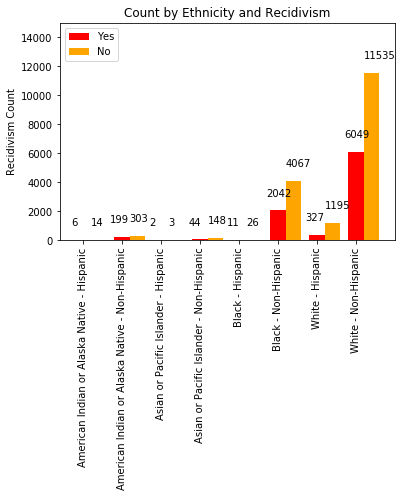

In [74]:
width = 0.4
yes_bar = plt.bar(ind, yes_count_list, width, color='red')

women_means = (25, 32, 34, 20, 25)
women_std = (3, 5, 2, 3, 3)
no_bar = plt.bar(ind + width, no_count_list, width, color='orange')

# creates labels
yes_no_count_list = []
for i in range(8):
    yes_no_count_list.append(yes_count_list[i])
    yes_no_count_list.append(no_count_list[i])
    
# adds the labels to the graph
for i in range(8):
    plt.text(x = ind[i] - 0.3, y = yes_no_count_list[2 * i] + 1000, s = yes_no_count_list[2 * i], size = 10)
    plt.text(x = ind[i] + 0.2, y = yes_no_count_list[2 * i + 1] + 1000, s = yes_no_count_list[2 * i + 1], size = 10)

plt.title('Count by Ethnicity and Recidivism')
plt.ylabel('Recidivism Count')
plt.xticks(ind, ethnic_list, rotation=90)
plt.ylim([0, 15000])
plt.yticks(np.arange(0, 15000, 2000))
plt.legend((yes_bar[0], no_bar[0]), ('Yes', 'No'), loc=2)

plt.show()

# Models

## Neural Network Reference:
Guides to how to write your own neural network:<br>
https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 <br>
https://towardsdatascience.com/inroduction-to-neural-networks-in-python-7e0b422e6c24

```python
class NeuralNetwork:
    def __init__(self, x, y):
        self.input      = x
        self.weights    = np.random.rand(self.input.shape[1], 1)
        self.y          = y
        
    # activation function ==> S(x) = 1/1+e^(-x)
    def sigmoid(self, x, deriv=False):
        if deriv == True:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    # calculating predicted value y_hat
    def feedforward(self):
        self.layer1 = self.sigmoid(np.dot(self.input, self.weights))
        
    # used to propogate errors back and update weights
    def backpropagation(self):
        error = self.y - self.layer1
        delta = error * self.sigmoid(self.layer1, deriv=True)
        self.weights += np.dot(self.input.T, delta)

    # train the neural net for 250 iterations
    def train(self, epochs=250):
        for epoch in range(epochs):
            # flow forward and produce an output
            self.feedforward()
            # go back though the network to make corrections based on the output
            self.backpropagation()    

    # function to predict output on new and unseen input data                               
    def predict(self, new_input):
        prediction = self.sigmoid(np.dot(new_input, self.weights))
        count = 0
        list1 = []
        for pred in prediction:
            if pred[0] == 0.:
                count += 1
            if pred[0] not in list1:
                list1.append(pred[0])
        print(count, len(prediction))
        return prediction, list1
```

```python 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

features_matrix = features_df
labels_matrix = labels_df

# creating the binarized label for each unique value
enc = preprocessing.LabelBinarizer()
categorical_feature_mask = features_matrix.dtypes==object
categorical_cols = features_matrix.columns[categorical_feature_mask].tolist()
features_matrix = features_matrix.replace(np.nan, -1)

for entry in categorical_cols:
    features_matrix.reset_index(drop=True, inplace=True)
    enc.fit(features_matrix[entry].astype(str))
    transformed = enc.transform(features_matrix[entry].astype(str))
    df = pd.DataFrame(transformed)
    print(df)
    features_matrix = pd.concat([features_matrix, df], axis=1).drop([entry], axis=1)

# encode labels_df strings
labels_matrix.replace({'Yes': 1, 'No': 0})

# split data into training and test data
x_train, x_test, y_train, y_test = train_test_split(features_matrix, labels_matrix, test_size=0.2, random_state=1)

features_matrix
```

```python
# create neural network   
NN = NeuralNetwork(x_train, y_train)

# train neural network
NN.train(20)

recidivism_pred, list1 = NN.predict(x_test)
print(list1)

recidivism_pred
```

## Decision Tree
### Creating the Model without Race

In [75]:
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import metrics

In [76]:
# changing objects to integers
enc = preprocessing.LabelBinarizer()
copy = features_df
categorical_feature_mask = copy.dtypes==object
categorical_cols = copy.columns[categorical_feature_mask].tolist()
copy = copy.replace(np.nan, -1)

In [77]:
# creating a data frame with binarized values
for entry in categorical_cols:
    copy.reset_index(drop=True, inplace=True)
    enc.fit(copy[entry].astype(str))
    transformed = enc.transform(copy[entry].astype(str))
    df = pd.DataFrame(transformed)
    copy = pd.concat([copy, df], axis=1).drop([entry], axis=1)

In [78]:
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(copy, labels_df, test_size=0.2, random_state=3)

In [79]:
# creating a graph to show which depth is the best
index = -1
max = -1
for i in range(1,25):
    dt = tree.DecisionTreeClassifier(max_depth=i)
    dt.fit(x_train, y_train)
    y_hat = dt.predict(x_test)
    if (metrics.accuracy_score(y_test, y_hat) > max):
        max = metrics.accuracy_score(y_test, y_hat)
        index = i

In [80]:
# using the best depth to to create the decision tree classifier
dt = tree.DecisionTreeClassifier(max_depth=index)
dt.fit(x_train, y_train)
y_hat = dt.predict(x_test)

### Statistics

In [81]:
print("--- Decision Tree: Recidivism Predictions Without Race ---")
print("Accuracy:", metrics.accuracy_score(y_test, y_hat))
print("Precision:", metrics.precision_score(y_test, y_hat, average=None, zero_division=1))
print("Recall:", metrics.recall_score(y_test, y_hat, average=None))

--- Decision Tree: Recidivism Predictions Without Race ---
Accuracy: 0.6673724735322425
Precision: [0.67442794 0.50234742]
Recall: [0.9694172  0.06188548]


In [82]:
arr = np.unique(y_hat)
values = [0,0]
for entry in y_hat:
    for i in range(arr.size):
        if entry == arr[i]:
            values[i] += 1

print(arr)
print(values)

['No' 'Yes']
[4982, 213]


In [83]:
arr2 = np.unique(y_test)
values2 = [0,0]
for entry in y_test.values:
    for i in range(arr2.size):
        if entry == arr2[i]:
            values2[i] += 1
            
print(arr2)
print(values2)

['No' 'Yes']
[3466, 1729]


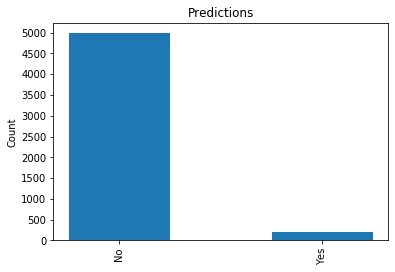

In [84]:
# graphing prediction vs actual recidivism count
width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values, width)
plt.title('Predictions')
plt.ylabel('Count')
plt.xticks(ind, arr, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()

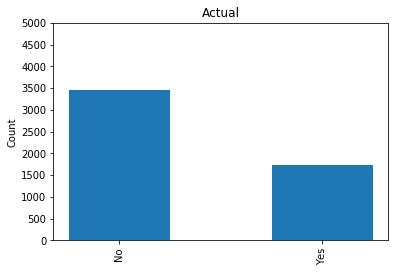

In [85]:
width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values2, width)
plt.title('Actual')
plt.ylabel('Count')
plt.xticks(ind, arr2, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()

### Creating the Model with Race

In [86]:
features_list3 = ['Release Type', 'Age At Release ', 'Offense Classification', 'Offense Type', 'Target Population', 'Race - Ethnicity']
features_df3 = iowa_clean_df[features_list3]
enc3 = preprocessing.LabelBinarizer()
copy3 = features_df3

categorical_feature_mask = copy3.dtypes==object
categorical_cols = copy3.columns[categorical_feature_mask].tolist()

print(copy3.shape)

(25971, 6)


In [87]:
for entry in categorical_cols:
    copy3.reset_index(drop=True, inplace=True)
    enc3.fit(copy3[entry].astype(str))
    transformed = enc3.transform(copy3[entry].astype(str))
    df = pd.DataFrame(transformed)
    copy3 = pd.concat([copy3, df], axis=1).drop([entry], axis=1)
    
print(copy3.shape)

(25971, 46)


In [88]:
x_train, x_test, y_train, y_test = train_test_split(copy3, labels_df, test_size=0.2, random_state=3)

In [89]:
index = -1
max = -1
for i in range(1,25):
    dt = tree.DecisionTreeClassifier(max_depth=i)
    dt.fit(x_train, y_train)
    y_hat = dt.predict(x_test)
    if (metrics.accuracy_score(y_test, y_hat) > max):
        max = metrics.accuracy_score(y_test, y_hat)
        index = i

In [90]:
dt = tree.DecisionTreeClassifier(max_depth=index)
dt.fit(x_train, y_train)
y_hat = dt.predict(x_test)

### Statistics

In [91]:
print("--- Decision Tree: Recidivism Predictions With Race ---")
print("Accuracy:", metrics.accuracy_score(y_test, y_hat))
print("Precision:", metrics.precision_score(y_test, y_hat, average=None, zero_division=1))
print("Recall:", metrics.recall_score(y_test, y_hat, average=None))

arr = np.unique(y_hat)
values = [0,0]
for entry in y_hat:
    for i in range(arr.size):
        if entry == arr[i]:
            values[i] += 1
print(arr)
print(values)

--- Decision Tree: Recidivism Predictions With Race ---
Accuracy: 0.6691049085659287
Precision: [0.6757899  0.52212389]
Recall: [0.96884016 0.06824754]
['No' 'Yes']
[4969, 226]


In [92]:
arr2 = np.unique(y_test)
values2 = [0,0]
for entry in y_test.values:
    for i in range(arr2.size):
        if entry == arr2[i]:
            values2[i] += 1
    
print(arr2)
print(values2)

['No' 'Yes']
[3466, 1729]


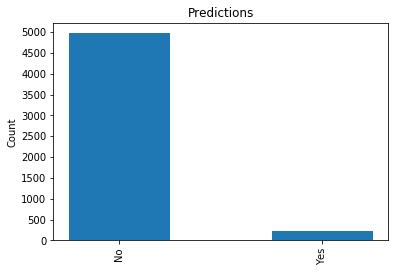

In [93]:
width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values, width)
plt.title('Predictions')
plt.ylabel('Count')
plt.xticks(ind, arr, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()

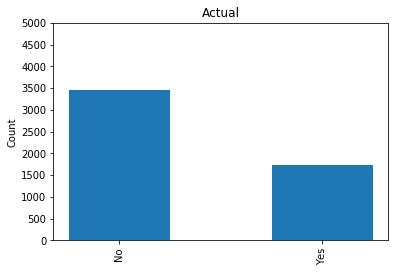

In [94]:
width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values2, width)
plt.title('Actual')
plt.ylabel('Count')
plt.xticks(ind, arr2, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()

### Predicting Race

In [95]:
features_list2 = ['Return to Prison', 'New Offense Classification','New Offense Type', 'New Offense Sub Type', 'Recidivism Type', 'Release Type', 'Age At Release ', 'Offense Classification', 'Offense Type', 'Target Population']
features_df2 = iowa_clean_df[features_list2]
labels_df2 = iowa_clean_df[['Race - Ethnicity']]

In [96]:
enc2 = preprocessing.LabelBinarizer()
copy2 = features_df2
categorical_feature_mask = copy2.dtypes==object
categorical_cols = copy2.columns[categorical_feature_mask].tolist()
copy2 = copy2.replace(np.nan, -1)

print(copy2.shape)

(25971, 10)


In [97]:
for entry in categorical_cols:
    copy2.reset_index(drop=True, inplace=True)
    enc2.fit(copy2[entry].astype(str))
    transformed = enc2.transform(copy2[entry].astype(str))
    df = pd.DataFrame(transformed)
    copy2 = pd.concat([copy2, df], axis=1).drop([entry], axis=1)
    
print(copy2.shape)

(25971, 95)


In [98]:
x_train, x_test, y_train, y_test = train_test_split(copy2, labels_df2, test_size=0.2, random_state= 3)

In [99]:
index = -1;
max = -1;
err2 = [];
x_example = np.array(range(1,25));
for i in range(1,25):
    dt = tree.DecisionTreeClassifier(max_depth=i)
    dt.fit(x_train, y_train)
    y_hat = dt.predict(x_test)
    err2.append(1 - metrics.accuracy_score(y_test, y_hat));
    if (metrics.accuracy_score(y_test, y_hat) > max):
        max = metrics.accuracy_score(y_test, y_hat)
        index = i

print(index)

6


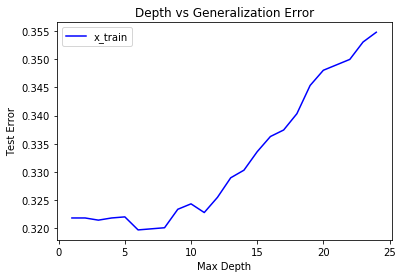

In [100]:
x_label = 'Max Depth'
y_label = 'Test Error'
plt.title('Depth vs Generalization Error')
plt.xlabel(x_label)
plt.ylabel(y_label)

plt.plot(x_example, err2, color='blue', label='x_train');
plt.legend()
plt.show()

In [101]:
dt = tree.DecisionTreeClassifier(max_depth=index)
dt.fit(x_train, y_train)
y_hat = dt.predict(x_test)

### Statistics

In [102]:
print("---Decision Tree: Race Predictions---")
print("Accuracy:", metrics.accuracy_score(y_test, y_hat))
print("Precision:", metrics.precision_score(y_test, y_hat, average=None))
print("Recall:", metrics.recall_score(y_test, y_hat, average=None))
print("CM: ", metrics.confusion_matrix(y_test, y_hat, labels=ethnic_list))

---Decision Tree: Race Predictions---
Accuracy: 0.6802694898941289
Precision: [0.         0.         0.         0.66666667 0.         0.54666667
 0.7826087  0.68178249]
Recall: [0.         0.         0.         0.05714286 0.         0.0329582
 0.05960265 0.99087019]
CM:  [[   0    0    0    0    0    0    0    5]
 [   0    0    0    0    0    0    0   94]
 [   0    0    0    0    0    0    0    1]
 [   0    0    0    2    0    0    2   31]
 [   0    0    0    0    0    0    0    9]
 [   0    0    0    0    0   41    2 1201]
 [   0    0    0    1    0    3   18  280]
 [   0    0    0    0    0   31    1 3473]]


In [103]:
arr = np.unique(y_hat)
values = [0,0,0,0]
for entry in y_hat:
    for i in range(arr.size):
        if entry == arr[i]:
            values[i] += 1
            
print(arr)
print(values)

['Asian or Pacific Islander - Non-Hispanic' 'Black - Non-Hispanic'
 'White - Hispanic' 'White - Non-Hispanic']
[3, 75, 23, 5094]


In [104]:
arr2 = np.unique(y_test)
values2 = [0,0,0,0,0,0,0,0]
for entry in y_test.values:
    for i in range(arr2.size):
        if entry == arr2[i]:
            values2[i] += 1
            
print(arr2)
print(values2)

['American Indian or Alaska Native - Hispanic'
 'American Indian or Alaska Native - Non-Hispanic'
 'Asian or Pacific Islander - Hispanic'
 'Asian or Pacific Islander - Non-Hispanic' 'Black - Hispanic'
 'Black - Non-Hispanic' 'White - Hispanic' 'White - Non-Hispanic']
[5, 94, 1, 35, 9, 1244, 302, 3505]


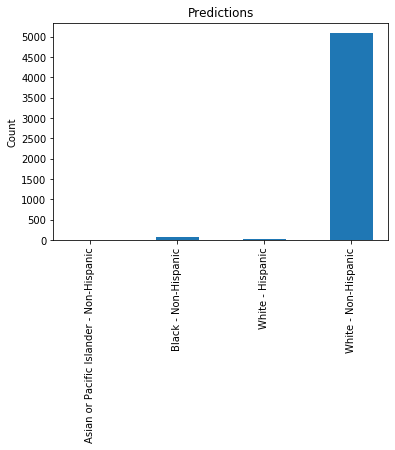

In [105]:
# clears graph to be reused
plt.clf()

width = 0.5
ind = np.arange(len(values)) 
p1 = plt.bar(ind, values, width)
plt.title('Predictions')
plt.ylabel('Count')
plt.xticks(ind, arr, rotation=90)
plt.yticks(np.arange(0, 5500, 500))
plt.show()

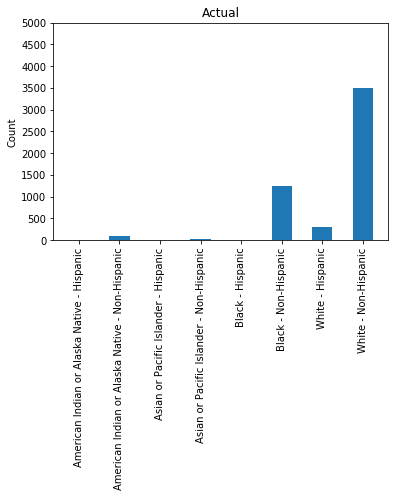

In [106]:
width = 0.5
ind = np.arange(8) 
p1 = plt.bar(ind, values2, width)
plt.title('Actual')
plt.ylabel('Count')
plt.xticks(ind, arr2, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()

## Random Forest Classifier
### Creating a Model Predicting Race

In [107]:
def precision(y, y_hat):
    true_positive = 0
    false_positive = 0
    for i in range(len(y)):
        if y_hat[i] == 1 and y[i] == y_hat[i]:
            true_positive += 1
        elif y_hat[i] == 1 and y[i] != y_hat[i]:
            false_positive += 1
    if (true_positive + false_positive) == 0:
        return 0
    return true_positive / (true_positive + false_positive)

In [108]:
# encoding strings
race_dict = {'White - Non-Hispanic': 0,
             'White - Hispanic': 1,
             'Black - Non-Hispanic': 2,
             'American Indian or Alaska Native - Non-Hispanic': 3,
             'Black - Hispanic': 4,
             'Asian or Pacific Islander - Non-Hispanic': 5,
             'American Indian or Alaska Native - Hispanic': 6,
             'Asian or Pacific Islander - Hispanic': 7
            }

In [109]:
y_train_float = y_train.replace(race_dict)
y_train_float = y_train_float.values

In [110]:
from sklearn import ensemble

rF = ensemble.RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
rF.fit(x_train.values, y_train_float.ravel())
predictionRF = rF.predict(x_test)

In [111]:
# display accuracy
y_test_ravel = y_train_float.ravel()
count = 0
for i in range(len(predictionRF)):
    if predictionRF[i] == y_test_ravel[i]:
        count += 1
        
print(count / len(predictionRF))

0.63888354186718


In [112]:
y_test_float = y_test.replace(race_dict)
y_test_float = y_test_float.values.ravel()

In [113]:
precision_int = precision(y_test_float, predictionRF)
print(precision_int)

0.44642857142857145


### Statistics

In [ ]:
from sklearn import metrics
metrics.precision_score(y_test_float, predictionRF, average=None, zero_division=1)
print(metrics.classification_report(y_test_float, predictionRF,zero_division=1))

## Logistic Regression
### Creating a Model without Race

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from scipy.special import expit
from sklearn import metrics
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# change all dtypes to "category"
features_df["Release Type"] = features_df["Release Type"].astype("category")
features_df["Age At Release "] = features_df["Age At Release "].astype("category")
features_df["Offense Classification"] = features_df["Offense Classification"].astype("category")
features_df["Offense Type"] = features_df["Offense Type"].astype("category")
features_df["Target Population"] = features_df["Target Population"].astype("category")
labels_df["Return to Prison"] = labels_df["Return to Prison"].astype("category")

In [ ]:
# encoding strings
le = preprocessing.LabelEncoder()

features_df["Release Type"] = features_df["Release Type"].cat.codes
features_df['Age At Release '] = features_df['Age At Release '].cat.codes
features_df["Offense Classification"] = features_df["Offense Classification"].cat.codes
features_df["Offense Type"] = features_df["Offense Type"].cat.codes
features_df["Target Population"] = features_df["Target Population"].cat.codes 

In [ ]:
le.fit(labels_df["Return to Prison"])
labels_df["Return to Prison"] = labels_df["Return to Prison"].cat.codes

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.2, random_state=0)

In [ ]:
# creating the model
list1 = y_test.index.tolist()
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
y_hat_with_race = logisticRegr.predict(x_test)

### Statistics

In [ ]:
count = 0
for i in range(len(y_hat)):
    if(y_hat[i]==1):
        count+=1

print(logisticRegr.score(x_test, y_test))
print(logisticRegr.coef_)
print(metrics.precision_score(y_test, y_hat_with_race, average=None))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_hat_with_race))

### Creating a Model without Race

In [ ]:
features_list3 = ['Release Type', 'Age At Release ', 'Offense Classification', 'Offense Type', 'Target Population', 'Race - Ethnicity']
features_df3 = iowa_clean_df[features_list3]

In [ ]:
# change all dtypes to "category"
features_df3["Release Type"] = features_df3["Release Type"].astype("category")
features_df3["Age At Release "] = features_df3["Age At Release "].astype("category")
features_df3["Offense Classification"] = features_df3["Offense Classification"].astype("category")
features_df3["Offense Type"] = features_df3["Offense Type"].astype("category")
features_df3["Target Population"] = features_df3["Target Population"].astype("category")
features_df3['Race - Ethnicity'] = features_df3['Race - Ethnicity'].astype("category")

In [ ]:
# encoding strings
labels_df["Return to Prison"] = labels_df["Return to Prison"].astype("category")
le = preprocessing.LabelEncoder()

features_df3["Release Type"] = features_df3["Release Type"].cat.codes
features_df3['Age At Release '] = features_df3['Age At Release '].cat.codes
features_df3["Offense Classification"] = features_df3["Offense Classification"].cat.codes
features_df3["Offense Type"] = features_df3["Offense Type"].cat.codes
features_df3["Target Population"] = features_df3["Target Population"].cat.codes 

In [ ]:
le.fit(labels_df["Return to Prison"])
labels_df["Return to Prison"] = labels_df["Return to Prison"].cat.codes
features_df3['Race - Ethnicity'] = features_df3['Race - Ethnicity'].cat.codes

In [ ]:
x1_train, x1_test, y1_train, y1_test = train_test_split(features_df3, labels_df, test_size=0.2, random_state=0)

In [ ]:
# creating the model
logisticRegr1 = LogisticRegression()
logisticRegr1.fit(x1_train, y1_train)
y_hat_without_race = logisticRegr1.predict(x1_test)

### Statistics

In [ ]:
print(metrics.precision_score(y_test, y_hat_without_race, average=None))
print(logisticRegr1.score(x1_test, y1_test))
print(classification_report(y_test, y_hat_without_race))

In [ ]:
# counts the number of 'yes'/'no' predictions
def count_recidivism(y_hat):
    no_count = 0
    yes_count = 0
    no_yes_count = []
    
    for i in range(len(y_hat)):
        if y_hat[i] == 0:
            no_count += 1
        else:
            yes_count += 1
    
    no_yes_count.append(no_count)
    no_yes_count.append(yes_count)
    
    return no_yes_count

In [ ]:
# create x-axis labels
arr = ['No', 'Yes']

In [ ]:
# following creates a graph where race is included as a feature
values1 = count_recidivism(y_hat_with_race)

width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values1, width)
plt.title('Predictions')
plt.ylabel('Count')
plt.xticks(ind, arr, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()

print(values1)

In [ ]:
# following creates a graph where race is not included as a feature
values2 = count_recidivism(y_hat_without_race)

width = 0.5
ind = np.arange(2) 
p1 = plt.bar(ind, values2, width)
plt.title('Predictions')
plt.ylabel('Count')
plt.xticks(ind, arr, rotation=90)
plt.yticks(np.arange(0, 5500, 500))

plt.show()

print(values2)